# CYCLOPS on Mouse Liver Data

This notebook explores the application of CYCLOPS on Mouse Liver data after data pre-preprocessing using PCA.

## 1. Importing packages

In [1]:
from cyclops_v2 import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

Read the Hughes Liver data into a pandas dataframe:

In [2]:
df = pd.read_csv("mouseLiver.csv").T
df = df.iloc[1:,:]

In [3]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 14312 genes and 48 cells.


## 3. Data Preprocessing

Filter genes in the top 10% variance:

In [4]:
frac = 0.10

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1431 entries, 4414 to 48
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1431 non-null   float64
dtypes: float64(1)
memory usage: 22.4 KB


In [5]:
gene_list = df_std.index.to_numpy()

In [6]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(48, 1431)

## SVD

Before performing SVD, the dataset has to be centered to zero mean and scaled to unit variance:

In [7]:
from sklearn import preprocessing
df_std = pd.DataFrame(preprocessing.scale(newdata), columns=newdata.columns, index=newdata.index)

#### Perform singular value decomposition (SVD) 

_Note: If the data was only centered but not scaled to unit variance, it would not be possible to carry out singular value decomposition (doesn't converge)._

SVD states that any matrix A can be factorized as:

$$
A = USV^H
$$


where $U$ and $V$ are orthogonal matrices with orthonormal eigenvectors of $AA^T$ and $A^TA$ respectively. $S$ is a diagonal matrix with singular values, which are the root of the positive eigenvalues of $AA^T$ or $A^TA$ (both have identical positive eigenvalues). The diagonal elements of $S$ are composed of singular values.

In [8]:
'The shape of the data matrix (M x N) is {} x {}'.format(df_std.shape[0], df_std.shape[1])

'The shape of the data matrix (M x N) is 48 x 1431'

#### Hence, M = 48 and N = 9471. K = min(M, N) = 48

In [9]:
svd = np.linalg.svd(df_std, full_matrices=True)

U, S, Vh = svd[0], svd[1], svd[2]

U.shape, S.shape, Vh.shape

((48, 48), (48,), (1431, 1431))

Printing out the singular values:

In [10]:
S

array([1.62686894e+02, 1.15907494e+02, 8.35794931e+01, 5.89328584e+01,
       5.22665966e+01, 4.18517317e+01, 3.68893985e+01, 3.60062587e+01,
       3.34460473e+01, 3.20764439e+01, 2.70042588e+01, 2.56470241e+01,
       2.40894997e+01, 2.35199450e+01, 2.22220271e+01, 2.05351270e+01,
       1.96161466e+01, 1.87888656e+01, 1.79009782e+01, 1.76558850e+01,
       1.70331615e+01, 1.63582761e+01, 1.56447703e+01, 1.53494171e+01,
       1.49987121e+01, 1.45261845e+01, 1.42480482e+01, 1.35472675e+01,
       1.33040748e+01, 1.30381479e+01, 1.28957800e+01, 1.22718090e+01,
       1.19895252e+01, 1.18132626e+01, 1.15889317e+01, 1.14888040e+01,
       1.13270856e+01, 1.11691903e+01, 1.09076329e+01, 1.09024387e+01,
       1.04186067e+01, 1.02934397e+01, 1.01452094e+01, 9.98877933e+00,
       9.48325859e+00, 9.11463789e+00, 8.85763578e+00, 4.91931546e-13])

Next, **normalise** the singular values so that they add up to 1:

In [11]:
S_norm = (S**2)/(sum(S**2))
S_norm

array([3.85322406e-01, 1.95587981e-01, 1.01699448e-01, 5.05631522e-02,
       3.97710971e-02, 2.55003413e-02, 1.98117244e-02, 1.88744856e-02,
       1.62857862e-02, 1.49793014e-02, 1.06165559e-02, 9.57619739e-03,
       8.44840435e-03, 8.05363113e-03, 7.18929780e-03, 6.13923015e-03,
       5.60204415e-03, 5.13949265e-03, 4.66522564e-03, 4.53835130e-03,
       4.22386136e-03, 3.89577797e-03, 3.56334205e-03, 3.43006936e-03,
       3.27511885e-03, 3.07200729e-03, 2.95549263e-03, 2.67191442e-03,
       2.57684614e-03, 2.47486170e-03, 2.42110911e-03, 2.19248334e-03,
       2.09277771e-03, 2.03169655e-03, 1.95526638e-03, 1.92162556e-03,
       1.86790806e-03, 1.81619515e-03, 1.73212870e-03, 1.73047940e-03,
       1.58029591e-03, 1.54255331e-03, 1.49844621e-03, 1.45259307e-03,
       1.30928537e-03, 1.20947798e-03, 1.14223316e-03, 3.52312844e-30])

In this normalised form, the statistical interpretation of singular values is in the form of **variance** in the data explained by the various components. The singular values produced by _np.linalg.svd()_ are in order from largest to smallest.

Next, compute the cumulative variance explained by the singular values:

In [12]:
S_cumsum = np.cumsum(S_norm)

#### Choose singular values that retain up to 90% of the variance:

In [13]:
variance_retained = 0.90

S_reduced = [S[i] if i == 0 or S_cumsum[i-1] <= variance_retained else 0 for i in range(len(S_cumsum))]

rg = np.count_nonzero(S_reduced)
'Singular values remaining: {}/{}'.format(rg, len(S))

'Singular values remaining: 14/48'

In [14]:
dim = np.count_nonzero(S_reduced)
svd_eigengenes = pd.DataFrame(U * S_reduced).iloc[:, :dim]

#### SVD Eigengenes:

In [15]:
print(svd_eigengenes.shape)
svd_eigengenes.head()

(48, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-8.941391,-13.262683,19.159595,-3.485712,7.198381,-4.464091,9.096506,-7.041814,0.218666,-1.268117,3.484227,-1.755072,1.655554,-3.428244
1,-7.742419,-14.310303,12.606860,2.782325,9.234894,-2.974321,1.000828,-7.745109,-2.176487,-0.137818,5.322766,0.834970,2.837021,-2.862337
2,-6.167382,-13.785133,10.161873,4.271927,13.749102,-0.292412,0.618820,-5.322749,-3.131525,-0.591121,5.500197,0.781359,-0.676517,-0.438514
3,-6.607067,-13.610199,2.030940,8.772525,12.606491,1.545626,-3.859432,-8.639207,3.715956,2.198816,0.173705,-2.738906,-4.236070,-3.195775
4,-18.590985,-13.004371,3.866711,-6.722292,14.013717,5.852695,-6.673182,5.447008,-2.947375,-2.539470,2.093149,-6.388730,-1.484205,-0.731018


## PCA

#### Perform principal component analysis (PCA)

In [16]:
from sklearn.decomposition import PCA
pca_model = PCA()
pca_comp = pca_model.fit_transform(df_std)
pca_load = pca_model.components_

In [17]:
pca_comp.shape, pca_load.shape

((48, 48), (48, 1431))

In [18]:
pca_comp

array([[-8.94139093e+00, -1.32626833e+01,  1.91595947e+01, ...,
        -5.75217071e-01,  1.63160319e+00,  1.04280275e-14],
       [-7.74241897e+00, -1.43103034e+01,  1.26068601e+01, ...,
         3.11871733e+00, -2.45522305e+00,  1.04280275e-14],
       [-6.16738220e+00, -1.37851325e+01,  1.01618727e+01, ...,
         9.26334086e-01, -8.88779764e-01,  1.04280275e-14],
       ...,
       [ 5.29712625e+01,  4.02407387e-01, -1.56254265e+00, ...,
        -7.76493905e-04,  8.79006454e-01,  1.04280275e-14],
       [ 5.57623226e+01, -2.96609214e+00, -5.01530700e+00, ...,
         8.53629265e-02, -7.35663030e-01,  1.04280275e-14],
       [ 5.30216266e+01, -1.15401776e+01, -8.60177966e+00, ...,
         2.69415171e-01,  5.86652713e-01,  1.04280275e-14]])

#### PCA Eigengenes:

In [19]:
pca_eigengenes = pd.DataFrame(pca_comp[:, 0:(sum(np.cumsum(pca_model.explained_variance_ratio_) < variance_retained) + 1)])

In [20]:
print(pca_eigengenes.shape)
pca_eigengenes.head()

(48, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-8.941391,-13.262683,19.159595,3.485712,-7.198381,-4.464091,9.096506,-7.041814,0.218666,1.268117,-3.484227,-1.755072,-1.655554,3.428244
1,-7.742419,-14.310303,12.606860,-2.782325,-9.234894,-2.974321,1.000828,-7.745109,-2.176487,0.137818,-5.322766,0.834970,-2.837021,2.862337
2,-6.167382,-13.785133,10.161873,-4.271927,-13.749102,-0.292412,0.618820,-5.322749,-3.131525,0.591121,-5.500197,0.781359,0.676517,0.438514
3,-6.607067,-13.610199,2.030940,-8.772525,-12.606491,1.545626,-3.859432,-8.639207,3.715956,-2.198816,-0.173705,-2.738906,4.236070,3.195775
4,-18.590985,-13.004371,3.866711,6.722292,-14.013717,5.852695,-6.673182,5.447008,-2.947375,2.539470,-2.093149,-6.388730,1.484205,0.731018


The signs of the components produced using SVD and PCA are arbitrary - this has to be adjusted before comparing the two methods.

In [21]:
svd_signs = np.sign(svd_eigengenes.loc[0])
pca_signs = np.sign(pca_eigengenes.loc[0])

toggle_signs = [a*b for a,b in zip(svd_signs, pca_signs)]
pca_eigengenes *= toggle_signs

#### Check if the eigengenes produced by SVD and PCA are the same:

In [22]:
svd_eigengenes.round(5).equals(pca_eigengenes.round(5))

True

#### Reducing the dimensionality using SVD and PCA produced the same eigengenes.

Plotting the first 3 eigengenes:

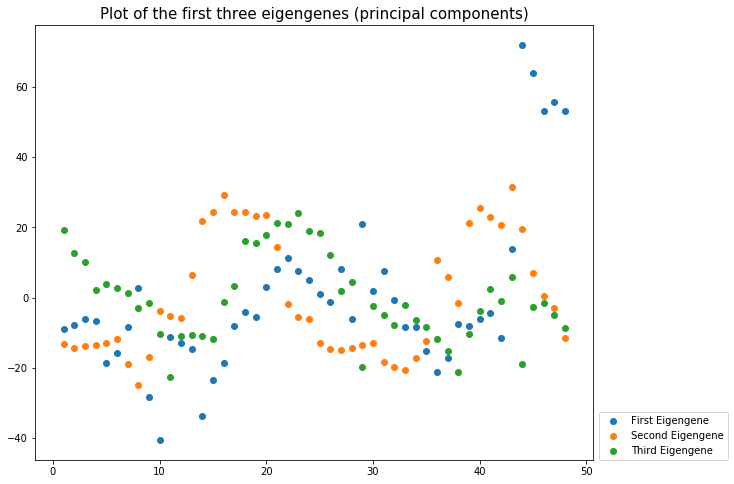

In [23]:
times = np.linspace(1,nc,nc)

plt.figure(figsize=(10,8))
plt.scatter(times, pca_eigengenes.iloc[:, 0], label="First Eigengene")
plt.scatter(times, pca_eigengenes.iloc[:, 1], label="Second Eigengene")
plt.scatter(times, pca_eigengenes.iloc[:, 2], label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components)', size=15)
plt.legend(loc=[1.01,0])
plt.show()

## PCA (without scaling)

Center the data to zero mean, without scaling to unit variance:

In [24]:
df_cent = newdata.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430
0,-1.074904,-1.346862,-0.435143,0.581335,0.291266,-0.404934,-0.572699,-0.080760,-0.366932,0.833576,...,0.192984,0.016707,-0.168378,0.126847,0.111669,0.021330,-0.269509,0.289797,0.158908,-0.112113
1,-1.325239,-1.478688,-0.945180,-0.105732,0.199204,-0.312123,-0.350296,-0.312390,-0.287158,0.804969,...,0.063094,0.154394,-0.129119,0.318367,0.104156,0.091646,-0.010063,0.500482,0.177918,-0.111686
2,-1.467395,-1.152329,-0.665212,0.202131,0.111784,-0.396584,-0.252562,0.372546,-0.382673,0.879127,...,0.197245,0.186623,-0.117351,0.115919,0.038757,-0.006018,-0.001137,0.360755,0.029727,0.083421
3,-1.796292,-1.381943,-0.281816,-0.385229,-0.180603,-0.444568,-0.191849,-0.311879,-0.344652,0.879681,...,0.168560,-0.093592,-0.012391,0.133560,0.207740,-0.030000,0.427969,0.259766,-0.067842,0.014793
4,-1.986607,-1.288099,-1.167620,-1.071924,-0.228164,-0.524226,-0.173404,-0.820587,-0.269711,0.805292,...,0.370957,0.061670,0.112919,0.165661,0.456097,-0.001966,0.271655,0.373738,0.194568,-0.249469


Perform PCA:

In [25]:
from sklearn.decomposition import PCA
pca_model = PCA()
pca_comp = pca_model.fit_transform(df_cent)
pca_load = pca_model.components_

In [26]:
pca_comp.shape, pca_load.shape

((48, 48), (48, 1431))

In [27]:
pca_comp

array([[-3.24054959e+00,  4.51063969e+00, -9.22488338e+00, ...,
        -4.87728076e-01,  4.86982889e-01,  4.06701634e-15],
       [-3.47670900e+00,  5.33167195e+00, -6.73297933e+00, ...,
         1.49557321e+00, -7.28464403e-01,  4.06701634e-15],
       [-3.16037532e+00,  5.18663430e+00, -5.67434035e+00, ...,
         4.63166180e-01, -4.34047875e-01,  4.06701634e-15],
       ...,
       [ 2.01151734e+01,  3.50374038e+00,  2.12901435e-01, ...,
        -1.06994659e-01,  2.28667958e-01,  4.06701634e-15],
       [ 2.04432226e+01,  5.30955008e+00,  2.12507804e+00, ...,
         1.71347721e-01, -2.37369928e-01,  4.06701634e-15],
       [ 1.79812763e+01,  9.26798453e+00,  3.19234244e+00, ...,
         7.68103458e-02,  3.40860447e-01,  4.06701634e-15]])

#### PCA Eigengenes:

In [28]:
pca_eigengenes = pd.DataFrame(pca_comp[:, 0:(sum(np.cumsum(pca_model.explained_variance_ratio_) < variance_retained) + 1)])

In [29]:
print(pca_eigengenes.shape)
pca_eigengenes.head()

(48, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,-3.240550,4.510640,-9.224883,0.737368,1.551798,0.283810,-0.872573,-5.133460,-0.997482,0.241793,-1.164166,-0.390126
1,-3.476709,5.331672,-6.732979,-0.293004,3.631337,0.142203,-0.062758,-2.540531,0.808756,0.308068,-0.185089,-1.994699
2,-3.160375,5.186634,-5.674340,-0.507193,5.377678,1.506100,1.028168,-1.720212,0.962416,1.029713,-1.831904,-1.538371
3,-4.409927,5.800370,-2.047162,-1.010509,6.427309,0.454001,0.456320,-1.267312,4.175300,-2.405567,0.397162,-0.005322
4,-8.059224,4.733938,-3.966139,-1.080819,3.155171,5.935077,-0.000366,2.794429,-0.766829,0.562829,-0.755025,0.854606


__Clip__ the values in each eigengene to deal with outliers:

In [30]:
pca_eigengenes = pca_eigengenes.clip(np.percentile(pca_eigengenes, 5, axis=0), np.percentile(pca_eigengenes, 95, axis=0), axis=1)
pca_eigengenes.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-3.240550,4.510640,-8.440872,0.737368,1.551798,0.283810,-0.872573,-3.604274,-0.997482,0.241793,-1.164166,-0.390126
1,-3.476709,5.331672,-6.732979,-0.293004,3.631337,0.142203,-0.062758,-2.540531,0.808756,0.308068,-0.185089,-1.994699
2,-3.160375,5.186634,-5.674340,-0.507193,5.233189,1.506100,1.028168,-1.720212,0.962416,1.029713,-1.831904,-1.538371
3,-4.409927,5.800370,-2.047162,-1.010509,5.233189,0.454001,0.456320,-1.267312,4.027233,-2.405567,0.397162,-0.005322
4,-8.059224,4.733938,-3.966139,-1.080819,3.155171,5.598742,-0.000366,2.794429,-0.766829,0.562829,-0.755025,0.854606


Sort the eigengenes in descending order of variance:

In [31]:
eig_std = np.array(pca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([ 0,  1,  2,  5,  4,  3,  6,  7,  8,  9, 11, 10])

Reorder the columns of the dataframe in descending order of variance:

In [32]:
pca_eigengenes = pca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

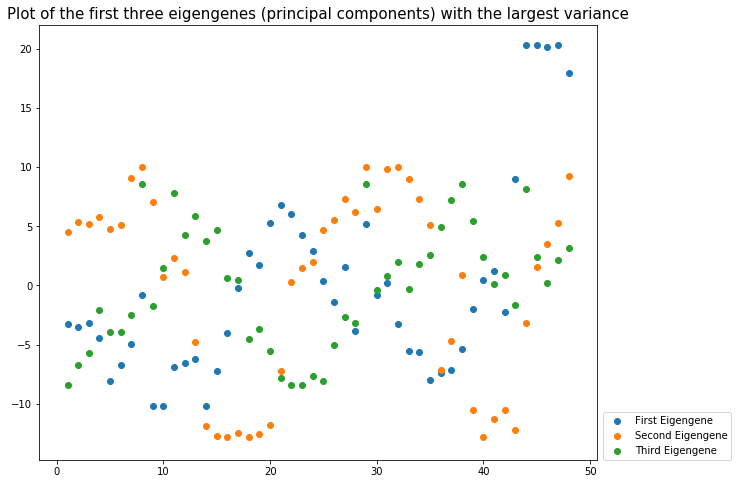

In [33]:
times = np.linspace(1,nc,nc)

eg1 = pca_eigengenes.iloc[:,0]
eg2 = pca_eigengenes.iloc[:,1]
eg3 = pca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

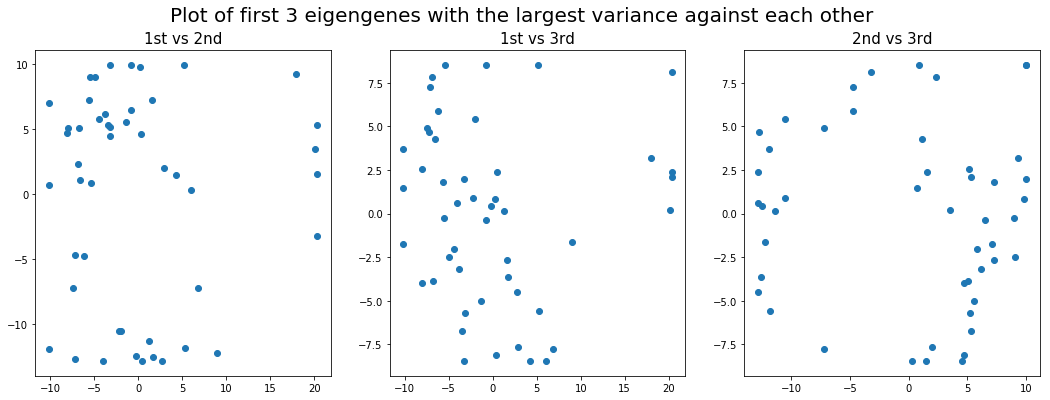

In [34]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

For consistency, we will use the eigengenes produced by PCA on the unscaled data:

In [35]:
data = pca_eigengenes.to_numpy()

In [36]:
model = cyclops(data.shape[1])

In [37]:
model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 12)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 12)           0           input_layer[0][0]                
__________________________________________________________________________________________________
hidden_input (Dense)            (None, 5)            65          dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5)            0           hidden_input[0][0]               
_______________________________________________________________________________________

### Training the model

In [38]:
history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=300, verbose=50, batch_size=10)

epoch: 50/300, loss: -0.5601, time elapsed:  1.42s, time left:  7.10s
epoch: 100/300, loss: -0.5015, time elapsed:  1.80s, time left:  3.61s
epoch: 150/300, loss: -0.5652, time elapsed:  2.16s, time left:  2.16s
epoch: 200/300, loss: -0.5999, time elapsed:  2.55s, time left:  1.28s
epoch: 250/300, loss: -0.5523, time elapsed:  2.88s, time left:  0.58s
epoch: 300/300, loss: -0.6397, time elapsed:  3.34s, time left:  0.00s


#### Plot the loss of the model to check if it has converged:

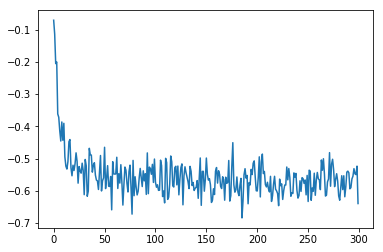

In [39]:
plt.plot(history.history['loss'])

## 5. Results and analysis

Print a dataframe of phase values generated from the autoencoder, and sort the rows according to increasing pseudotime values:

In [40]:
phase_df = model.phase_output(data)
phase_df.head()

,pseudotime
2,-3.062133
29,-2.965996
27,-2.940979
30,-2.938686
3,-2.817506


#### $z_p$ and $z_q$ are the values of each circular node in the bottleneck layer, from which the pseudotime (phase) values were extracted using argtan operations.

Next, print the lists of indices (which are the sample collection times) and phase values:

In [41]:
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()
phase_idx, phase_list

(array([ 2, 29, 27, 30,  3,  6,  4,  5, 31, 32,  8, 33, 34,  7,  9, 10, 11,
        37, 35, 36, 12, 13, 14, 38, 15, 39, 41, 40, 16, 18, 17, 42, 19, 20,
        43, 44, 21, 22, 45, 46, 23, 47, 24, 28, 25,  0, 26,  1]),
 array([-3.0621328 , -2.965996  , -2.9409792 , -2.9386861 , -2.817506  ,
        -2.807061  , -2.7166164 , -2.7043507 , -2.6871188 , -2.647642  ,
        -2.4901729 , -2.4702694 , -2.0819883 , -1.9069813 , -1.9034108 ,
        -1.7071791 , -1.4833583 , -1.1633368 , -0.66961205, -0.64878875,
        -0.62037396, -0.5284557 , -0.3500356 , -0.10960258, -0.06322108,
        -0.02596495, -0.00376373,  0.14127749,  0.16004789,  0.28861514,
         0.350962  ,  0.4579033 ,  0.50419885,  1.0395749 ,  1.2094537 ,
         1.7624209 ,  1.846728  ,  2.0108132 ,  2.0635345 ,  2.121362  ,
         2.260272  ,  2.5592604 ,  2.7641127 ,  2.895194  ,  2.9493887 ,
         2.9989514 ,  3.1161318 ,  3.12592   ], dtype=float32))

### Plotting

Produce a polar plot of phase values:

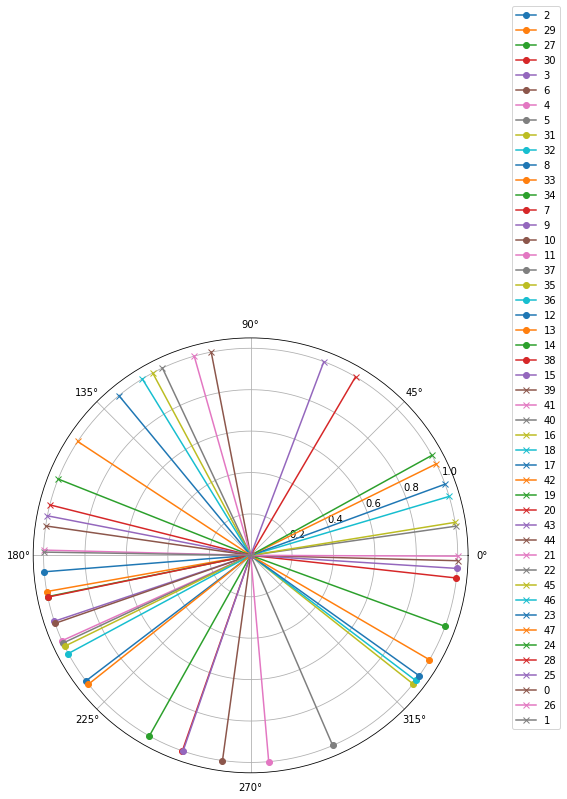

In [42]:
model.plot_polar(nc, phase_idx, phase_list)

#### Adjust and wrap phase values such that the phase at the first collection time (time 0) is zero:

In [43]:
idx = list(phase_idx).index(0)
phase_list -= phase_list[idx]

for i in range(len(phase_list)):
    if phase_list[i] > np.pi:
        phase_list[i] = -np.pi + (phase_list[i]-np.pi)
    elif phase_list[i] < -np.pi:
        phase_list[i] = np.pi - (-np.pi-phase_list[i])
        
phase_list

array([ 0.22210103,  0.3182376 ,  0.3432544 ,  0.34554797,  0.46672755,
        0.47717315,  0.5676177 ,  0.5798829 ,  0.59711486,  0.6365922 ,
        0.794061  ,  0.8139642 ,  1.2022456 ,  1.3772525 ,  1.380823  ,
        1.5770549 ,  1.8008755 ,  2.120897  ,  2.6146219 ,  2.635445  ,
        2.6638598 ,  2.755778  ,  2.9341981 , -3.1085541 , -3.0621724 ,
       -3.0249164 , -3.002715  , -2.857674  , -2.8389034 , -2.7103362 ,
       -2.6479895 , -2.541048  , -2.4947526 , -1.9593766 , -1.7894977 ,
       -1.2365305 , -1.1522235 , -0.9881382 , -0.93541694, -0.87758946,
       -0.7386794 , -0.43969107, -0.23483872, -0.10375738, -0.04956269,
        0.        ,  0.11718035,  0.12696862], dtype=float32)

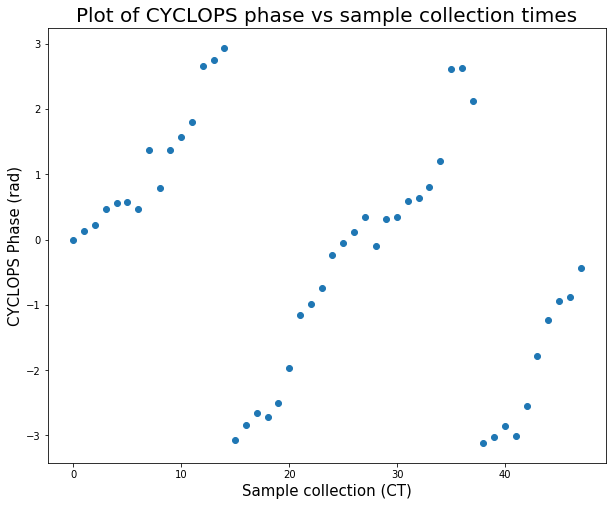

In [44]:
model.plot_phase_time(phase_idx, phase_list)

### Remapping

Create a dictionary of remapped sample indices according to increasing phase values:

In [45]:
remap_dict = model.remap(nc,phase_idx)

### Processing

#### Re-ordering the samples from the original dataset:

In [46]:
ori = df.to_numpy().T

new = np.zeros([ng,nc])
for i in range(ng):
    for key, val in remap_dict.items():
        new[i][val-1] = ori[i][key-1]

In [47]:
new.shape

(14312, 48)

#### Define a sinusoidal function to fit the reordered gene expressions. The function takes 4 parameters: intercept, amplitude, frequency and phase difference:

In [48]:
def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.sin(omega * x + phi)

#### Create a curve fitting function that fits an optimal sinusoid to expression data for every gene:

In [49]:
from scipy import optimize
def fit_(f, xdata, ydata):
    try:
        popt, pcov = optimize.curve_fit(f, xdata, ydata)

        #Residual sum of squares (ss_res):
        residuals = ydata - f(xdata, *popt)
        ss_res = np.sum(residuals**2)

        #Total sum of squares (ss_tot):
        ss_tot = np.sum((ydata - np.mean(ydata))**2)

        r_squared = 1 - (ss_res / ss_tot)   
            
        return popt, pcov, r_squared

    except:
        pass

#### Store the parameter, covariance and $R^2$ values in arrays:

In [50]:
%%time

phase_list = phase_df.pseudotime.to_numpy()
params, pcov = np.zeros([ng,4]), np.zeros([ng,4,4])
r_squared = np.zeros(ng)

for i in range(ng):
    try:
        params[i] = fit_(test_func, phase_list, new[i])[0]
        pcov[i] = fit_(test_func, phase_list, new[i])[1]
        r_squared[i] = fit_(test_func, phase_list, new[i])[2]
    except:
        continue

CPU times: user 1min 33s, sys: 254 ms, total: 1min 33s
Wall time: 1min 34s


In [51]:
params.shape, pcov.shape, r_squared.shape

((14312, 4), (14312, 4, 4), (14312,))

####  Create a dataframe of parameter and $R^2$ values and print:

_Note: if optimal parameters cannot be found for a particular gene, the parameter and $R^2$ values will be zero._

In [52]:
df_params = pd.DataFrame(params, columns=['intercept', 'amplitude', 'frequency', 'phase_shift'])
df_params['r_squared'] = r_squared

Sort the dataframe in descending order of $R^2$ values:

In [53]:
df_params = df_params.sort_values(by='r_squared', ascending = False)
df_params.head()

,intercept,amplitude,frequency,phase_shift,r_squared
7063,7.144911,1.483493,1.029938,1.042954,0.956479
7938,10.258356,1.290638,0.979100,0.539901,0.935563
10830,10.080814,0.518887,0.979660,0.753371,0.935343
865,9.022231,-1.089031,0.921967,0.598354,0.924725
4414,8.266238,-2.470899,1.015117,1.211676,0.920759


#### Plot the expression for the top 9 genes with the highest $R^2$ values:

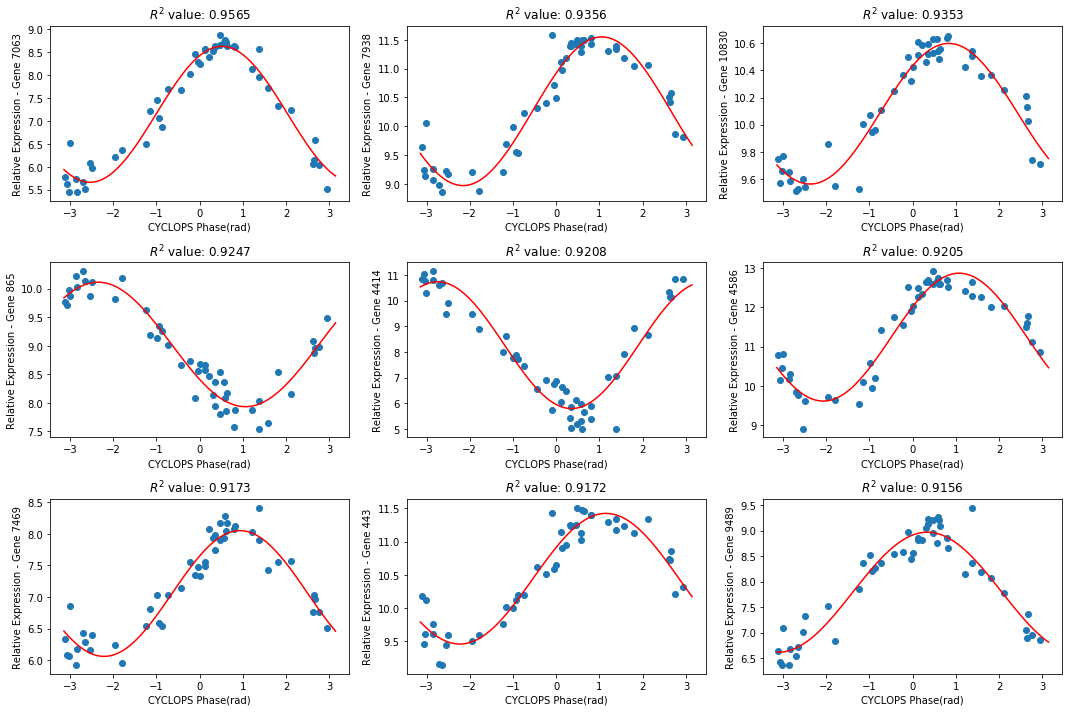

In [54]:
x = np.linspace(-np.pi,np.pi,100)

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(phase_list, new[df_params.index[i]])
    plt.plot(x, df_params.intercept.iloc[i]+df_params.amplitude.iloc[i]*np.sin(df_params.frequency.iloc[i]*x+df_params.phase_shift.iloc[i]), c='red')        
    plt.xlabel('CYCLOPS Phase(rad)')
    plt.ylabel('Relative Expression - Gene {}'.format(df_params.index[i]))
    plt.title('$R^2$ value: {:.4f}'.format(df_params.r_squared.iloc[i]))
    plt.tight_layout()

### Evaluating fit using R^2 values

#### Print the collection time indices reordered according to increasing index collection time values:

In [55]:
phase_df = model.phase_output(data)
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()

re_phase_idx = phase_df.sort_index().index.to_numpy()
re_phase_list = phase_df.sort_index()['pseudotime'].to_numpy()

re_phase_idx, re_phase_list

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([ 2.9989514 ,  3.12592   , -3.0621328 , -2.817506  , -2.7166164 ,
        -2.7043507 , -2.807061  , -1.9069813 , -2.4901729 , -1.9034108 ,
        -1.7071791 , -1.4833583 , -0.62037396, -0.5284557 , -0.3500356 ,
        -0.06322108,  0.16004789,  0.350962  ,  0.28861514,  0.50419885,
         1.0395749 ,  1.846728  ,  2.0108132 ,  2.260272  ,  2.7641127 ,
         2.9493887 ,  3.1161318 , -2.9409792 ,  2.895194  , -2.965996  ,
        -2.9386861 , -2.6871188 , -2.647642  , -2.4702694 , -2.0819883 ,
        -0.66961205, -0.64878875, -1.1633368 , -0.10960258, -0.02596495,
         0.14127749, -0.00376373,  0.4579033 ,  1.2094537 ,  1.7624209 ,
         2.0635345 ,  2.121362  ,  2.5592604 ], dtype=float32))

#### Determine the indices of phase jumps (in either direction) of absolute value greater than pi:

In [56]:
asc_phase_jump, desc_phase_jump = [],[]
for i in range(len(re_phase_list)-1):
    if re_phase_list[i+1]-re_phase_list[i] > np.pi:
        desc_phase_jump.append(i)
    elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
        asc_phase_jump.append(i)
        
asc_phase_jump, desc_phase_jump

([1, 26, 28], [27])

#### Function to remove anomalous jumps caused by noise in reorderings:

In [57]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    
    margin = 10
    for i in range(1,len(X)):
        if X[i]-X[i-1]<margin:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

In [58]:
if len(asc_phase_jump) > len(desc_phase_jump):
    phase_jump = asc_phase_jump
else:
    phase_jump = desc_phase_jump
    

phase_jump = jump_control(phase_jump)
phase_jump 

[1, 26]

#### Phase plots with red markers for identified jumps:

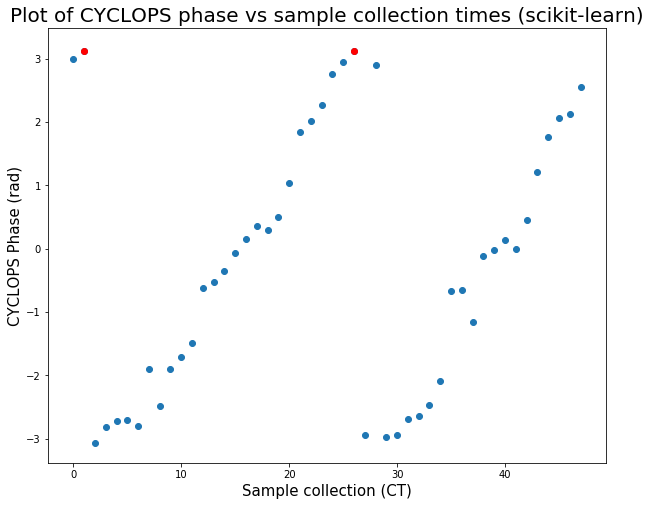

In [59]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.scatter(re_phase_idx[phase_jump], re_phase_list[phase_jump], marker='o', color="red")
plt.title(r'Plot of CYCLOPS phase vs sample collection times (scikit-learn)', size=20)
plt.xlabel('Sample collection (CT)', size=15)
plt.ylabel('CYCLOPS Phase (rad)', size=15)
plt.show()

#### Increment or decrement values in the phase list by 2$\pi$ based on the sign of the phase jumps:

In [60]:
jumps = len(phase_jump)
for i in range(jumps):
    if len(asc_phase_jump) > len(desc_phase_jump):
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(nc)])
    else:
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(nc)])
    phase_jump.pop(0)

#### Linear regression:

In [61]:
from scipy.stats import linregress

lin = linregress(re_phase_idx, re_phase_list)
lin

LinregressResult(slope=0.2630692532553987, intercept=2.3821420123254535, rvalue=0.9692483777624735, pvalue=1.1777705843238338e-29, stderr=0.009847825786296015)

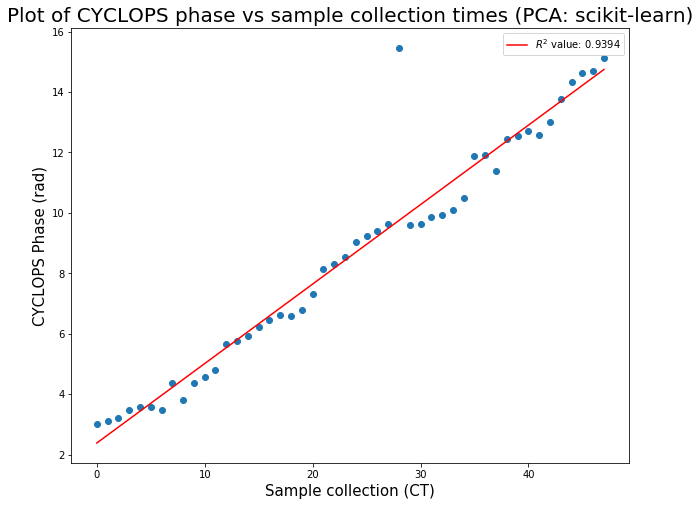

In [62]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.plot(re_phase_idx, lin[0]*re_phase_idx + lin[1], color='red', label='$R^2$ value: {:.4f}'.format(lin[2]**2))
plt.title(r'Plot of CYCLOPS phase vs sample collection times (PCA: scikit-learn)', size=20)
plt.xlabel('Sample collection (CT)', size=15)
plt.ylabel('CYCLOPS Phase (rad)', size=15)
plt.legend()
plt.show()